Здесь тот файл, что mdlj выдает будем приводить к моей csv-шке
---

In [56]:
import random
import os
import time

from numba import jit, njit, vectorize
import numpy as np
import scipy
from numpy.linalg import norm as norm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from tqdm import tqdm
import gc

from itertools import islice
from collections import defaultdict
import csv

In [57]:
# !rm *.csv *.xyz

In [58]:
# !./md -N 50 -ns 5000 -outf 1 -thermof 1000 -dt 0.0005 -T0 1.0

In [59]:
N = int(input())

In [60]:
!./md -N 2 -ns 5000 -outf 1 -thermof 1000 -dt 0.0001 -T0 1.0

# NVE MD Simulation of a Lennard - Jones fluid
# L = 2.5198421 rho = 0.125 N = 2 r_cut = 1000000
# Steps number = 5000 seed = 1677857795 dt = 0.0001
# step time PE KE TE drift T
0 0 -0.75 3 2.25 0 1
1000 0.1 -0.89173503 3.141735 2.25 -1.7745819e-09 1.047245
2000 0.2 -0.89640371 3.1464037 2.25 -1.7024683e-09 1.0488012
3000 0.3 -0.76336644 3.0133664 2.25 -3.0578957e-10 1.0044555
4000 0.4 -0.54188617 2.7918862 2.25 4.603708e-09 0.93062873
5000 0.5 -0.78609515 3.0358642 2.2497691 -0.00010262425 1.0119547
2.5198421


In [61]:
L = 2 * N ** (1 / 3)
L

2.5198420997897464

In [62]:
read_path = f'N{N}.xyz'

In [63]:
# NUMPY VERSION:

def csv_from_xyz(read_path=read_path, velocity_regime=None, skip_part=0.5):
    '''

    '''
    # через решейп к (lines_read, 3) - удаляем с шагом строчки: x = np.delete(x, np.arange(0, x.size, use_particles))

    with open(read_path, 'r+') as read_f:
        all_vels = []
        all_coords = []
        lines_read = 0  # строчки с координатами прочитанные
        for line in (read_f):
            if line[0] != 'L' and len(line) > 5:    # ЗДЕСЬ 5 - ТИПО РАЗМЕР СТРОЧКИ ГДЕ КОЛ-ВО АТОМОВ ЗАПИСАНО - МОЖЕТ ОШИБКУ ВЫЗВАТЬ    
                # if lines_read in actual_steps:
                    # if lines_read % (N * step) == 0:    # делаем шаг

                    line = line[2:]  # ЭТО ТОЖЕ МОЖЕТ ВЫЗВАТЬ ОШИБКУ - ЕСЛИ НЕТ НАЧАЛЬНОГО "1" ИЛИ "C"
                    arr = list(map(lambda x: float(x.strip()), line.split(' ')))
                    arr_coords = (arr[:3])
                    arr_vels = (arr[3:])
                    all_vels.extend(arr_vels)
                    all_coords.extend(arr_coords)
                    lines_read += 1

    all_coords = np.reshape(all_coords, (lines_read // N, 3 * N))
    all_vels = np.reshape(all_vels, (lines_read // N, 3 * N))

    # CFG.N = N
    coords_path = 'coords' + str(N) + '.csv'
    velocities_path = 'velocities' + str(N) + '.csv'

    fieldnames_vels = []
    fieldnames_coords = []
    for i in range(N):
        fieldnames_coords.extend([str(i) + 'x', str(i) + 'y', str(i) + 'z'])

        fieldnames_vels.extend([str(i) + "v_x", str(i) + "v_y", str(i) + "v_z"])

    if not velocity_regime:
        df_coords = pd.DataFrame(all_coords,
                    index=np.arange(len(all_coords)),
                    columns=fieldnames_coords)[int(skip_part * len(all_coords)):]     # на старте там паника какая-то происходит - откидываем стартовые точки
        df_coords.index.name = 't'
        df_coords.to_csv(coords_path)

    df_vels = pd.DataFrame(all_vels,
                index=np.arange(len(all_vels)),
                columns=fieldnames_vels).iloc[int(skip_part * len(all_vels)):]
    df_vels.index.name = 't'
    df_vels.to_csv(velocities_path)

In [64]:
csv_from_xyz(skip_part=0.5)

In [65]:
@njit
def pot_energy(r1, r2):
    # Snaps particle back to the unfolded coordinate
    r1 = r1 % L
    r2 = r2 % L
    r = r1 - r2
    for i in range(3):
        if np.abs(r[i]) > L / 2:   # Если расстояние между двумя частицами больше L/2, то мы точно найдем в соседних клетках ближе
            r[i] = r[i] - L * np.sign(r[i])

    d = norm(r)
    return -4 * (pow(d, -6) - pow(d, -12))

def plot_energy(N=N, path_coords=f"coords{N}.csv", path_vels=f"velocities{N}.csv"):
    E = []
    try:
        coords = pd.read_csv(path_coords).drop(columns=["t"])
        vels = pd.read_csv(path_vels).drop(columns=["t"])
    except:
        coords = pd.read_csv(path_coords)
        vels = pd.read_csv(path_vels)
    
    for row_n in tqdm(range(len(vels))):  # TODO: ЗДЕСЬ СТОИТ vels ПОТОМУ ЧТО У МЕНЯ ПОКА БАГА И В КООРДС НА ОДНУ СТРОЧКУ БОЛЬШЕ ПОЧЕМУ-ТО...
        V = 0
        T = 0
        for i in range(N):
            r_i = np.array(coords.iloc[row_n, (3 * i):(3 * i) + 3])

            for j in range(i + 1, N):
                r_j = np.array(coords.iloc[row_n, (3 * j):(3 * j) + 3])
                # print(r_i, r_j)
                V += pot_energy(r_i, r_j)
        

        T = ((vels.iloc[row_n]) ** 2).sum() / 2
        E.append(T + V)

        # print(
        #     f'{row_n}: K = {T}, V = {V}, E = {T + V}'
        # )

    plt.figure(figsize=(10, 10))
    plt.plot(
        [i for i in range(len(E))], E
    )

    avg_E = np.array(E).mean()

    # print(E)

    plt.ylim([-0.1 + avg_E, 0.1 + avg_E])
    # plt.xlabel()

In [66]:
# создаем фолдед координаты:
df = pd.read_csv(f"coords{N}.csv") % L

df.to_csv(f"folded_coords{N}.csv")

100%|██████████| 2501/2501 [00:01<00:00, 1575.33it/s]


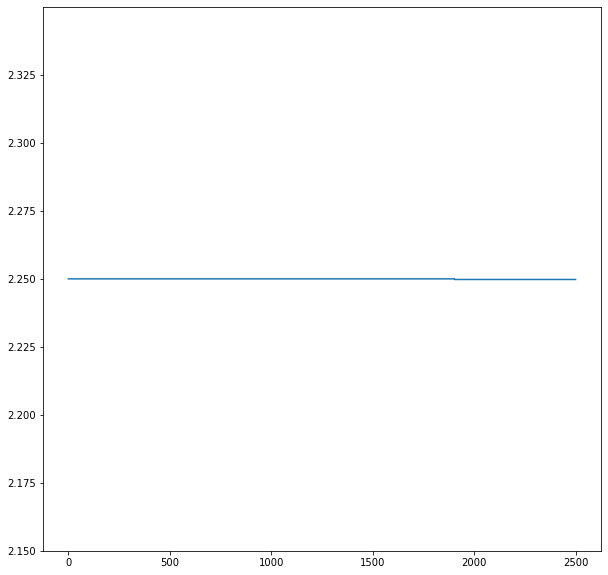

In [67]:
plot_energy()